In [3]:
import seaborn as sns
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import iglob
from funcy import project, omit

In [6]:
for exp_file in iglob("experiments/*.json"):
    exp = json.loads(Path(exp_file).read_text())
    if "results" in exp:
        # print(exp.keys())
        # print(omit(exp["results"], ["candidates"]))
        # print(exp["results"]["candidates"][-1].keys())
        print(exp_file)
        print(exp["results"]["candidates"][-1]["candidate"])
        print(exp["results"]["candidates"][-1]["metric"])


experiments/sk8syuzj.json
{'uuid': 'pf9rktre', 'demo_indices': [0, 1, 2, 3, 4, 5, 6, 7], 'prompt_pattern': 'cot', 'model': 'ibm/granite-13b-chat-v2'}
0.4162244124336619
experiments/h5gt4bh4.json
{'uuid': 'kbii4wiy', 'demo_indices': [0, 1, 2, 3, 4, 5, 6, 7], 'prompt_pattern': 'cot', 'model': 'ibm/granite-34b-code-instruct'}
0.7376800606520091
experiments/sud3twq8.json
{'uuid': 'u45quixp', 'demo_indices': [0, 1, 2, 3, 4, 5, 6, 7], 'prompt_pattern': 'cot', 'model': 'ibm/granite-13b-chat-v2'}
0.4233128834355828


In [50]:
exp = json.loads(Path("experiments/opdkb4tq.json").read_text())

In [51]:
exp["config"]

{'thread_class': "<class 'pdl.optimize.fever_thread.FEVERTrialThread'>",
 'max_candidates': 100,
 'num_candidates': 100,
 'starting_test_set_size': 10,
 'ending_test_set_size': 10000,
 'num_iterations': 7,
 'total_evaluations': 6000,
 'num_threads': 5,
 'test_set_multiplier': 2,
 'patterns': ['cot', 'react', 'rewoo'],
 'budget': None,
 'shuffle_test': False,
 'candidates': [{'uuid': 'yn2n91kd',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'rewoo',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'x85u7zgz',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'cot',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'rzxtw1cd',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'react',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'y2mp0vpf',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'cot',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'silr4ig8',
   'demo_i

In [41]:
(exp["iterations"][0]["candidates"])

KeyError: 'candidates'

In [33]:
exp["iterations"][5]["candidates"][0]

{'candidate': {'uuid': 'xpetnj6f',
  'demo_indices': [6219, 4815, 1732, 157, 6025],
  'prompt_pattern': 'rewoo',
  'model': 'ibm/granite-13b-instruct-v2'},
 'results': [{'matches': True,
   'exception': 'None',
   'pdl_document': "For the following task, make plans that can solve the problem step by step. For each plan, indicate \nwhich external tool together with tool input to retrieve evidence. You can store the evidence into a \nvariable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)\n\nTools can be one of the following:\n(1) Search[<query>]: Search Wikipedia for a summary\n\nTask: On June 2017, the following claim was made: The elevation range for the area that the eastern sector of the Colorado orogeny extends into is 1,800 to 7,000 ft.\nQ: Was this claim true or false?\nPlan: I need to search Colorado orogeny, find the area that the eastern sector of the Colorado ... #E1 = Search[Colorado orogeny]\n\nTask: On June 2017, the following claim was made: Profe

In [37]:
len(exp["iterations"][0]["candidates"][0]["results"])

10

In [12]:
[ exp["iterations"][-1]["candidates"][i]["candidate"]["prompt_pattern"] for i in range(3) ]

['rewoo', 'rewoo', 'rewoo']

In [13]:
[ exp["iterations"][-1]["candidates"][i]["metric"] for i in range(3) ]

[0.65, 0.65, 0.65]

In [69]:
exp["config"]

{'thread_class': "<class 'pdl.optimize.fever_thread.FEVERTrialThread'>",
 'max_candidates': 100,
 'num_candidates': 100,
 'starting_test_set_size': 10,
 'ending_test_set_size': 10000,
 'num_iterations': 7,
 'total_evaluations': 6000,
 'num_threads': 5,
 'test_set_multiplier': 2,
 'patterns': ['cot', 'react', 'rewoo'],
 'budget': None,
 'shuffle_test': False,
 'candidates': [{'uuid': 'yn2n91kd',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'rewoo',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'x85u7zgz',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'cot',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'rzxtw1cd',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'react',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'y2mp0vpf',
   'demo_indices': [5390, 6266, 3880, 4662, 1958],
   'prompt_pattern': 'cot',
   'model': 'ibm/granite-20b-multilingual'},
  {'uuid': 'silr4ig8',
   'demo_i

In [72]:
uuids = { k:[] for k in exp["iterations"][0]["selected_candidates_uuids"] }
results = []
x = []
y = []
y_avg = []
for j, iteration in enumerate(exp["iterations"]):
    x.append(iteration['timestamp'])
    for i in iteration["candidates"]:
        uuids[i["candidate"]["uuid"]].append(i["metric"])
        results.append({"iteration": j, "uuid": i["candidate"]["uuid"], "metric": i["metric"], "test_set": len(i["results"])})
    scores = [i["metric"] for i in iteration["candidates"]]
    max_score = min(scores)
    avg = np.mean(scores)
    y.append(max_score)
    y_avg.append(avg)

In [73]:
results

[{'iteration': 0, 'uuid': 'yn2n91kd', 'metric': 0.8, 'test_set': 10},
 {'iteration': 0, 'uuid': 'x85u7zgz', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'rzxtw1cd', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'y2mp0vpf', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'silr4ig8', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'm82qstwb', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': '0y5l7yrd', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'd5ufxxoy', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'a84cmql6', 'metric': 0.8, 'test_set': 10},
 {'iteration': 0, 'uuid': '4vs5a0tk', 'metric': 0.8, 'test_set': 10},
 {'iteration': 0, 'uuid': 'hlc13b4l', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'debpue31', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'r82sepdk', 'metric': 0.6, 'test_set': 10},
 {'iteration': 0, 'uuid': 'cvzgnj2i', 'metric': 0.8, 'test_set': 10},
 {'iteration': 0, 'u

In [74]:
df = pd.DataFrame(results)

<Figure size 1000x600 with 0 Axes>

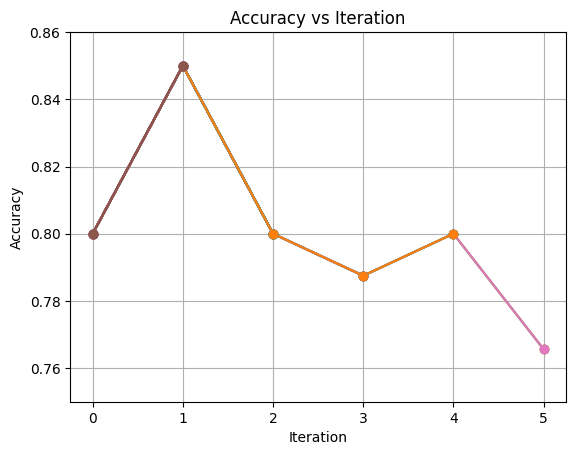

In [56]:
# Convert to DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in uuids.items()]))

# Plot the DataFrame
plt.figure(figsize=(10, 6))
df.plot(marker='o', legend=False)
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0.75, 0.86)
plt.show()

In [53]:
df

,2fr6kosm,xpetnj6f,k9ntd5qc,g1lxapcm,92pzn6da,j26nrcim,q8wybika,n4xebp47,w2wqx681,l36az37v,...,nddvp2jx,u8ljg0ww,6552u4mb,dfh0ucm2,k412gcj0,4z19qc9r,8pqaeywd,9i3s0pn8,265eatn9,w9i817e5
0,0.4,0.800000,0.800000,0.70,0.70,0.70,0.800000,0.4,0.8000,0.4,...,0.7,0.4,0.4,0.80,0.7,0.80,0.7,0.4,0.7,0.4
1,NaN,0.850000,0.850000,0.65,0.65,0.65,0.850000,NaN,0.8500,NaN,...,NaN,NaN,NaN,0.85,NaN,0.85,NaN,NaN,NaN,NaN
2,NaN,0.800000,0.800000,NaN,NaN,NaN,0.800000,NaN,0.8000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.787500,0.787500,NaN,NaN,NaN,0.787500,NaN,0.7875,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.800000,0.800000,NaN,NaN,NaN,0.800000,NaN,0.8000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.765625,0.765625,NaN,NaN,NaN,0.765625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Iteration')

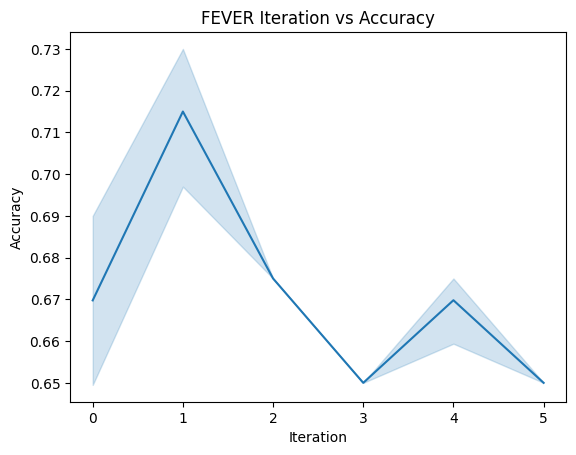

In [75]:
fig = sns.lineplot(df, x="iteration", y="metric")
fig.set_title("FEVER Iteration vs Accuracy")
fig.set_ylabel("Accuracy")
fig.set_xlabel("Iteration")

In [ ]:
fig = sns.lineplot(df, x="iteration", y="metric")
fig.set_title("FEVER Iteration vs Accuracy")
fig.set_ylabel("Accuracy")
fig.set_xlabel("Iteration")